# Explainable AI con algoritmi genetici

In questo notebook si prova ad analizzare un possibile approccio genetico a
problemi di explainable AI, prendendo un modello **Random Forest** come black
box di riferimento.

Di seguito cerco di proporre una metodologia applicabile a problemi di ogni
ordine di grandezza ma per semplicità tratterò un semplice problema di
classificazione in cui ogni punto è composto da due sole feature e le possibili
classi per ogni punto sono soltanto due.


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification


X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    shuffle=True,
    random_state=0,
)

df = pd.DataFrame({"feature1": X.T[0], "feature2": X.T[1], "class": y})
df

,feature1,feature2,class
0,1.070334,-0.929154,1
1,-0.475656,1.278883,0
2,0.885906,1.690195,1
3,1.365818,1.077153,1
4,-1.260713,0.895089,0
...,...,...,...
195,0.858270,2.063549,1
196,0.628935,2.615793,1
197,0.359017,-1.073006,1
198,-0.521872,0.578906,0


Proseguiamo con il dividere il dataset in training set e test set. Di seguito
un plot del training set.


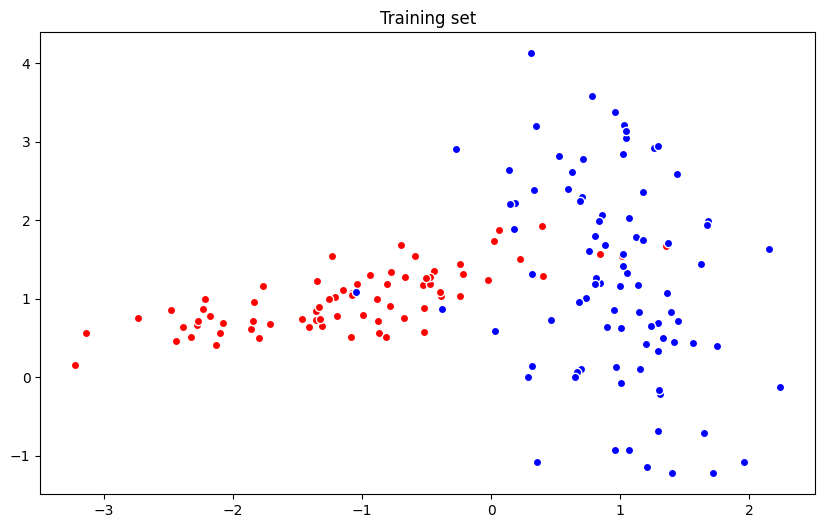

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

cls0 = [i for i in range(len(y_train)) if y_train[i] == 0]
cls1 = [i for i in range(len(y_train)) if y_train[i] == 1]

cmap = plt.get_cmap("Set1")
plt.figure(figsize=(10, 6))
plt.title("Training set")
plt.scatter(X_train.T[0][cls0], X_train.T[1][cls0], c="r", ec="w")
plt.scatter(X_train.T[0][cls1], X_train.T[1][cls1], c="b", ec="w")
plt.show()

Abbiamo quindi un training set e un test set su cui allenare e testare il
modello rispettivamente. Più precisamente non sfrutteremo la parte di test set
che ci fornisce la classe giusta per i punti classificati. Non è di nostro
interesse infatti testare la correttezza del modello.

Proseguiamo quindi con il training e la classificazione dei nuovi punti i quali
diventeranno centrali nella nostra analisi.


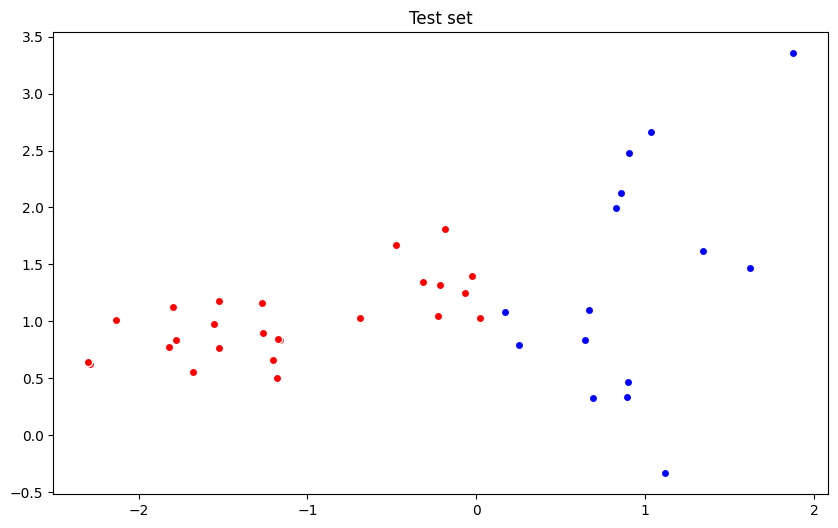

In [3]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_predicted = classifier.predict(X_test)

cls0 = [i for i in range(len(y_predicted)) if y_predicted[i] == 0]
cls1 = [i for i in range(len(y_predicted)) if y_predicted[i] == 1]
# cls0 = y_predicted[y_predicted == 0]

plt.figure(figsize=(10, 6))
plt.title("Test set")
plt.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
plt.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")
plt.show()

A questo punto prendiamo a caso uno dei punti classificati, di seguito
rappresentato con una X, che sarà il nostro punto di riferimento per tutto ciò
che andremo a fare.


point: (0.25188, 0.79000)
class: 1


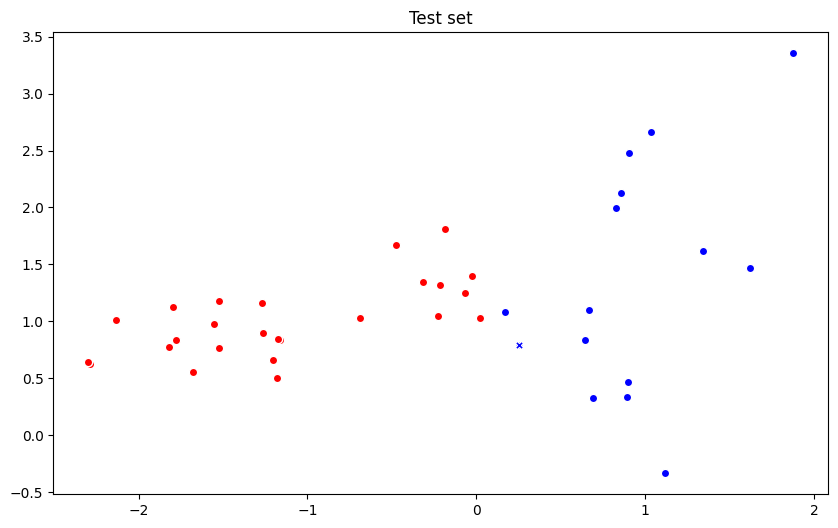

In [4]:
plt.figure(figsize=(10, 6))
plt.title("Test set")
plt.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
plt.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

j = 29
point = X_test[j]
print(f"point: ({point[0]:.5f}, {point[1]:.5f})")
point_class = y_predicted[j]
print(f"class: {point_class}")

c = "r" if point_class == 0 else "b"
plt.scatter(point[0], point[1], c=c, ec="w", marker="X")
plt.show()

## Algoritmo genetico

L'algoritmo genetico prevede di analizzare ogni singolo punto un numero di
volte pari al numero delle classi possibili (nel nostro caso solo due). Andremo
a definire due approcci volti a risolvere due problemi differenti:

1. Spiegare perché un determinato punto è stato classificato in un certo modo.
2. Capire come modificare le feature di quel punto il meno possibile per
   riuscire a classificarlo in tutte le altre possibili classi.

Come forma del cromosoma abbiamo semplicemente il vettore delle feature di
ciascun individuo.

### Generazione della popolazione iniziale

Come in ogni algoritmo genetico c'è bisogno di andare a generare una
popolazione iniziale. Nel nostro caso abbiamo bisogno che la popolazione
iniziale sia generata in modo che i nuovi individui siano simili a quello di
riferimento.

Per riuscire a generare una popolazione con queste caratteristiche possiamo
sfruttare la deviazione standard di ogni feature per generare un offset
coerente con il dataset che stiamo considerando su ogni asse.


In [5]:
sigma = X_test.std(axis=0)
sigma

array([1.17144131, 0.6751292 ])

I metodi utilizzabili sono principalmente tre:

- **Copie**: l'intera popolazione sintetica è composta da copie del punto di
  riferimento.
- **Uniforme**: si ottiene una popolazione sintetica equamente distribuita su
  ogni asse sfruttando un parametro $\alpha \in [0, 1]$ per regolare l'ampiezza
  dell'intervallo di valori. Intervallo definito in funzione della deviazione
  standard di ognuna delle feature. Avremo quindi che per ogni feature, lo
  spazio entro cui vengono generate le feature dei punti sintetici è il
  seguente
  $$[x_i - \sigma_i \cdot \alpha, \; x_ i + \sigma_i \cdot \alpha]$$
  dove $x_i$ è il valore dell'$i$-esima feature per il punto $x$ e $\sigma_i$ è
  la deviazione standard dell'$i$-esima feature rispetto a tutta la popolazione.
- **Normale**: in modo simile possiamo usare una distribuzione normale centrata
  nel valore della feature e usare sempre una frazione della deviazione
  standard piccola a piacere. Avremo quindi una distribuzione del tipo:
  $$N(x_i, \; \sigma_i \cdot \alpha)$$
  in cui $x_i$ è il valore dell'$i$-esima feature e $\sigma_i$ la sua
  deviazione standard.

Una distribuzione normale dovrebbe avere il vantaggio di riuscire a generare
i punti tenendo di conto della dispersione che ogni feature ha sul proprio asse.
In questo modo si riesce a produrre una nuvola di punti con una forma simile
a quella del dataset iniziale.

Una distribuzione uniforme riempe invece uno spazio arbitrariamente grande e
ben definito intorno al punto di riferimento. Potrebbe però non rispecchiare
la distribuzione dei punti del dataset di riferimento.


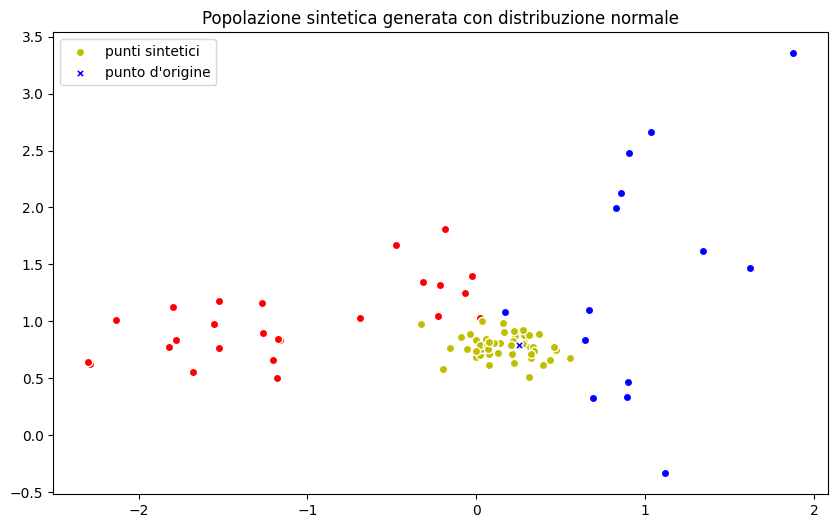

In [6]:
from numpy import random
from ppga import base


def generate_copy(point) -> np.ndarray:
    return point.copy()


def generate_uniform(point, sigma, alpha: float) -> np.ndarray:
    return random.uniform(point - sigma * alpha, point + sigma * alpha, size=point.shape)


def generate_normal(point, sigma, alpha: float) -> np.ndarray:
    return random.normal(point, alpha * sigma, size=point.shape)


toolbox = base.ToolBox()
# toolbox.set_generation(generate_copy, point=point)
# toolbox.set_generation(generate_uniform, point=point, sigma=sigma, alpha=0.15)
toolbox.set_generation(generate_normal, point=point, sigma=sigma, alpha=0.15)

# generazione di una popolazione composta da 50 individui
population = toolbox.generate(50)
synth_points = np.array([i.chromosome for i in population])

plt.figure(figsize=(10, 6))
plt.title("Popolazione sintetica generata con distribuzione normale")
plt.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
plt.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

plt.scatter(
    synth_points.T[0], synth_points.T[1], c="y", ec="w", label="punti sintetici"
)

c = "r" if point_class == 0 else "b"
plt.scatter(point[0], point[1], c=c, ec="w", marker="X", label="punto d'origine")

plt.legend()
plt.show()

### Crossover

Gli operatori di crossover da testare sono principalmente due:

- **One point** o **Two Points**: operatori standard per il crossover, in
  questo, avendo solo due feature, sarebbe inutile applicare un crossover a
  due o più punti.
- **Media delle feature**: ogni figlio ha una certa probabilità di
  ereditare l'$i$-esima feature così com'è dal padre o dalla madre. In
  alternativa l'$i$-esima feature del figlio sarà la media tra la feature
  $i$-esima del padre e la feature $i$-esima della madre.

Per i test andremo ad usare un semplice _one point crossover_ dato che abbiamo
solo due feature.


In [7]:
from ppga import tools


toolbox.set_crossover(tools.cx_one_point)
o1, o2 = toolbox.crossover(population[0], population[1])
print(f"father: {population[0].chromosome}")
print(f"mother: {population[1].chromosome}")
print(f"offspring 1: {o1.chromosome}")
print(f"offspring 2: {o2.chromosome}")

father: [0.14034491 0.80769193]
mother: [0.20794828 0.71292437]
offspring 1: [0.14034491 0.71292437]
offspring 2: [0.20794828 0.80769193]


Come possiamo vedere con due features andiamo semplicemente ad incrociare i
valori di padre e madre per generare due figli. Il problema di questo crossover
è che da solo non genera mai nuovi valori per le feature ma va ad esplorare
le possibili permutazioni di quelli già esistenti.

### Mutazione

L'operatore di mutazione andrà a modificare ogni feature di un termine
stocastico con una certa probabilità. Tale termine viene generato casualmente
tramite una distribuzione gaussiana. Ciò che potrebbe essere interessante è
variare il centro della distribuzione:

- Possiamo infatti centrare la gaussiana nel punto stesso in modo da generare
  un valore casuale con maggiore probabilità vicino al punto. In questo caso
  la distribuzione sarebbe la seguente:

  $$N(x_i, \; \alpha \cdot \sigma_i)$$

  centrata nel valore della feature $i$-esima ($x_i$) e con deviazione standard
  una frazione ($\alpha$) della deviazione standard di quella feature, calcolata
  sull'intera popolazione ($\sigma_i$).

  L'approccio è praticamente identico a quello usato per la generazione della
  popolazione sintetica tramite una distribuzione gaussiana.
- L'altra possibilità è centrare la distribuzione nella media globale del
  dataset, ottenendo quindi

  $$N(\mu_i, \; \alpha \cdot \sigma_i)$$

  dove $\mu_i$ è la media della feature $i$-esima calcolata sull'intero dataset.

Il primo approccio ha la caratteristica di essere più conservativo poiché tende
a generare valori intorno al punto di riferimento. Il secondo approccio tende
invece a favorire l'esplorazione dello spazio delle feature permettendo ai
punti che si trovano agli estremi del dataset di migrare verso il centro.

Ho però due considerazioni da fare:

1. Il primo approccio sembra più indicato nel caso si voglia giustificare la
   scelta del modello. Non ci interessa infatti esplorare lo spazio di lavoro
   in generale, ma solo l'intorno del punto di riferimento.
2. Il secondo approccio potrebbe essere migliore nel caso in cui si stia
   cercando di far cambiare classe ai punti sintetici. C'è però da tenere di
   conto che il boundary di classificazione potrebbe non trovarsi vicino alla
   media delle feature come in questo caso.

Sarebbe interessante vedere i due metodi applicati su dataset diversi. Dobbiamo
anche tener di conto che la funzione di valutazione giocherà poi un ruolo
fondamentale che ancora non abbiamo discusso.
   

In [8]:
def mut_gaussian_pt(individual, sigma, alpha: float = 0.05, indpb: float = 0.5):
    for i, f in enumerate(individual):
        if random.random() <= indpb:
            individual[i] = random.normal(loc=f, scale=sigma[i] * alpha)

    return individual


def mut_gaussian(individual, mu, sigma, alpha: float = 0.05, indpb: float = 0.5):
    for i, f in enumerate(individual):
        if random.random() <= indpb:
            individual[i] = random.normal(loc=mu[i], scale=sigma[i] * alpha)

    return individual


mu = X_test.mean(axis=0)
# toolbox.set_mutation(mut_gaussian_pt, sigma, 0.1, 0.8)
toolbox.set_mutation(mut_gaussian, mu, sigma, 0.2, 0.8)
print(f"before: {o1.chromosome}")
o1 = toolbox.mutate(o1)
print(f"after: {o1.chromosome}")

before: [0.14034491 0.71292437]
after: [-0.10731838  1.03718322]


L'operatore richiede quindi

- La deviazione standard $\sigma$ di tutte le feature, calcolata sull'intera
  popolazione
- Un parametro $\alpha$ che regola _l'intesità_ della mutazione
- La probabilità `indpb` che ogni singola feature ha di essere mutata.

### Funzione di valutazione

Passiamo ora ad uno dei punti cruciali dell'algoritmo, ossia la funzione di 
valutazione. Nel caso in cui si vogliano studiare solo due casistiche a
prescindere dal numero di classi sarebbe necessario scrivere due funzioni di 
valutazione differenti:

- Una che valuta bene i punti sintetici classificati come quello d'origine.
- L'altra che valuta bene i punti sintetici classificati in una qualsiasi altra
  classe.

L'approccio sfruttato in questo caso è leggermente diverso e ci permette di 
scrivere una sola funzione di valutazione. La funzione in questione prende in 
input la classe target in cui vogliamo che i punti sintetici siano classificati.

Per coprire il primo caso basterà fornire come classe target la classe del punto
di riferimento. Sarà poi necessario fornire come target tutte le altre classi
per riuscire a fare un'analisi pià completa.

Questo approccio ha lo svantaggio di dover eseguire $n$ volte l'algoritmo
genetico per ogni punto, dove $n$ è il numero di classi possibili. Ha però il
vantaggio di riuscire a fornire dei risultati più precisi per ogni classe
presente. Dato che nel nostro caso abbiamo solo due classi, i due approcci sono
equivalenti.

Il valore di fitness in sé dipende molto dalla **distanza euclidea** tra i
due punti. Sebbene l'obbiettivo sia minimizzare la distanza tra i punti
sintetici e il punto d'origine, non vogliamo che questi si avvicinino troppo
poiché non si otterrebbe alcuna informazione interessante. Vogliamo infatti
minimizzare la distanza ma mantenere un certo grado di separazione tra i punti
sintetici e quello di riferimento. Per mitigare il problema sarà sufficiente
calcolare un certo valore $\epsilon$ sotto il quale la distanza non può
scendere.

#### Implementazione

Dobbiamo quindi andare a definire una funzione basata su due parametri:

- **Classificazione**: la classificazione del punto sintetico rispetto alla
  classe target fornisce il primo metro di valutazione.
- **Distanza**: la distanza del punto sintetico da quello di riferimento
  fornisce un valore numerico su cui si baserà molto il valore di fitness
  finale.

L'implementazione mostrata di seguito fa uso di un parametro $\alpha$, il quale
offre la possibilità di bilanciare la corretta o errata classificazione del
punto sintetico rispetto alla classe target.

In [9]:
from numpy import linalg
import warnings

warnings.filterwarnings("ignore")


def evaluate(chromosome, point, target, classifier, epsilon: float = 0.0, alpha: float = 1.0):
    assert alpha >= 0.0 and alpha <= 1.0

    # classification
    synth_class = classifier.predict(chromosome.reshape(1, -1))

    # calcolo della distanza con norma euclidea
    distance = linalg.norm(chromosome - point, ord=2)

    # compute classification penalty
    right_target = alpha if target == synth_class[0] else 1.0 - alpha

    # check the epsilon distance
    epsilon = 0.0 if distance > epsilon else np.inf

    return (distance / right_target + epsilon,)


toolbox.set_weights((-1.0,))
epsilon = 0.0
# epsilon = linalg.norm(sigma * 0.1, ord=2)
toolbox.set_evaluation(evaluate, point, point_class, classifier, epsilon, 1.0)
population = list(map(toolbox.evaluate, population))

Abbiamo quindi una funzione che, oltre a parametri come il punto di
riferimento, la classe target e il classificatore, ha bisogno di 2 parametri
fondamentali:

- `epsilon`: valore minimo di distanza dal punto d'origine.
- `alpha`: coefficiente compreso tra 0 e 1.

La scelta di entrambi i valori rimane a carico del programmatore, in quanto
forniscono la base per analisi di tipo differente. Possiamo vedere il valore
di $\alpha$ come l'importanza che diamo alla "corretta" classificazione e di
conseguenza l'importanza che diamo alla classificazione "errata". Abbiamo
infatti che il valore di distanza effettivo calcolato è dato dalla seguente
funzione:

$$
    f(x, x_0) = \begin{cases}
       \frac{\| x - x_0 \|_2}{\alpha} & \text{se } C_x = C_t \\
       \frac{\| x - x_0 \|_2}{1 - \alpha} & \text{altrimenti}
    \end{cases}
$$

Dove $x$ e $C_x$ sono rispettivamente il punto sintetico e la sua classe, $x_0$
è il punto d'origine e $C_t$ la classe target. Ovviamente vogliamo mantenere un
valore di $\alpha$ maggiore o uguale di $0.5$ per ottenere l'effetto desiderato.
Il valore di default per $\alpha$ è tuttavia $1$, così da far diventare la
distanza di tutti i punti non classificati nella classe target $+\infty$. Più si
abbassa il valore di $\alpha$ e più si appiana la differenza di valutazione tra
punti con classi diverse.

Il valore $\epsilon$, che di default è a $0$, serve a scartare tutti i punti
che si avvicinano troppo. Quello che fa la funzione è semplicemente aggiungere
$+\infty$ alla distanza del punto qual'ora questo avesse una distanza dal punto
di riferimento inferiore a $\epsilon$.


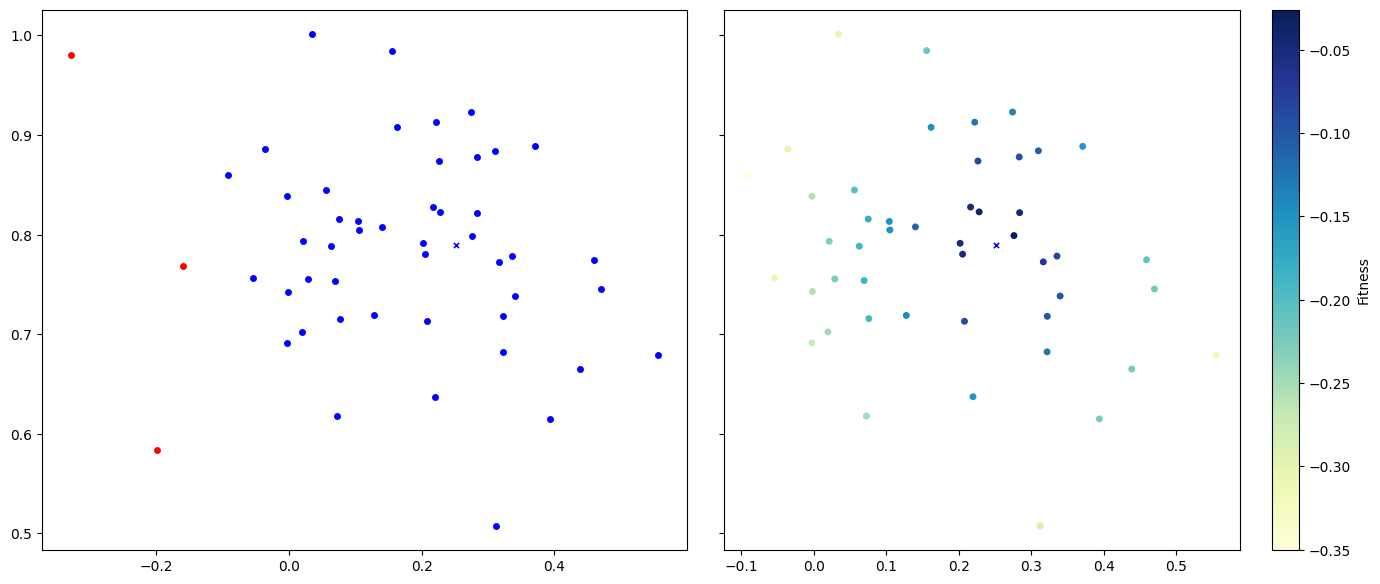

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
plt.tight_layout()

synth_classes = [classifier.predict(sp.reshape(1, -1)) for sp in synth_points]

scls0 = [i for i in range(len(synth_classes)) if synth_classes[i] == 0]
scls1 = [i for i in range(len(synth_classes)) if synth_classes[i] == 1]

# classification plot
ax1.scatter(synth_points[scls0].T[0], synth_points[scls0].T[1], c="r", ec="w")
ax1.scatter(synth_points[scls1].T[0], synth_points[scls1].T[1], c="b", ec="w")
ax1.scatter(point[0], point[1], c=c, ec="w", marker="X")

# fitness plot
fitness_values = [i.fitness for i in population]
sc = ax2.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("YlGnBu"),
)
fig.colorbar(sc, ax=ax2, label="Fitness")
ax2.scatter(point[0], point[1], c=c, ec="w", marker="X")

plt.show()

Come si può notare i punti classificati diversamente dal punto d'origine non 
compaiono neanche dato che abbiamo impostato $\alpha$ a $1$. Possiamo invece
notare come i punti rimasti abbiamo una fitness tanto più alto quanto più sono
vicini al punto d'origine. In questo caso abbiamo $\epsilon = 0$ ma, nel caso
avessimo avuto un valore più alto, anche alcuni dei punti classificati
correttamente sarebbero stati scartati.

Quando si vuole studiare come fare a cambiare classe ci basta cambiare classe 
target e rieseguire l'algoritmo.

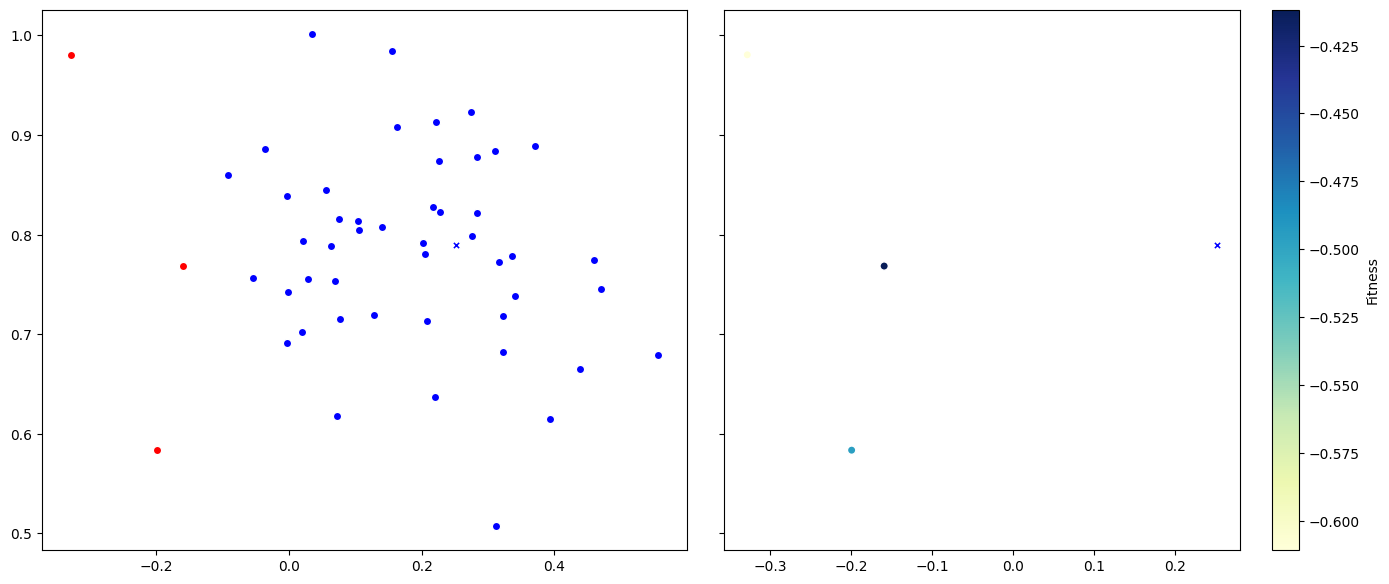

In [11]:
toolbox.set_weights((-1.0,))
target = (point_class + 1) % 2
toolbox.set_evaluation(evaluate, point, target, classifier, epsilon, 1.0)
population = list(map(toolbox.evaluate, population))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
plt.tight_layout()

synth_classes = [classifier.predict(sp.reshape(1, -1)) for sp in synth_points]

scls0 = [i for i in range(len(synth_classes)) if synth_classes[i] == 0]
scls1 = [i for i in range(len(synth_classes)) if synth_classes[i] == 1]

# classification plot
ax1.scatter(synth_points[scls0].T[0], synth_points[scls0].T[1], c="r", ec="w")
ax1.scatter(synth_points[scls1].T[0], synth_points[scls1].T[1], c="b", ec="w")
ax1.scatter(point[0], point[1], c=c, ec="w", marker="X")

# fitness plot
fitness_values = [i.fitness for i in population]
sc = ax2.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("YlGnBu"),
)
fig.colorbar(sc, ax=ax2, label="Fitness")
ax2.scatter(point[0], point[1], c=c, ec="w", marker="X")

plt.show()

### Simulazione caso 1

Entrambe le simulazioni verrano eseguite sullo stesso punto usato per gli
esempi. Per il momento ci occuperemo di effettuare una simulazione per la
prima casistica dell'algoritmo in cui cerchiamo di produrre individui simili
a quello iniziale e classificati allo stesso modo.

L'algoritmo usa una politica cosiddetta "elitista" regolata dal parametro
`keep`, il quale indica, in percentuale, quanta della vecchia generazione
vogliamo tenere. Nel nostro caso portiamo nella nuova generazione il 10%
dei migliori individui della vecchia generazione.


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.47it/s]


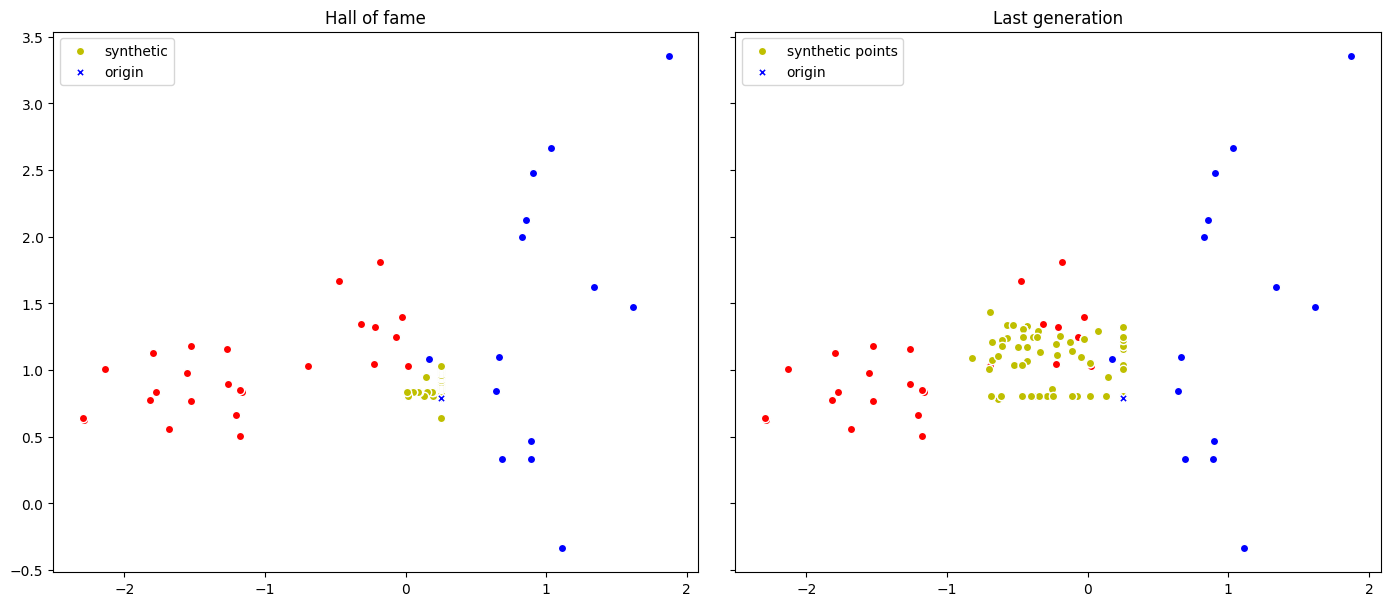

In [12]:
from ppga import algorithms, log

toolbox.set_generation(generate_copy, point)
toolbox.set_evaluation(evaluate, point, point_class, classifier, epsilon, 1.0)
toolbox.set_selection(tools.sel_tournament, tournsize=3)

hof = base.HallOfFame(50)
population, stats = algorithms.pelitist(
    toolbox=toolbox,
    population_size=500,
    keep=0.1,
    cxpb=0.8,
    mutpb=0.2,
    max_generations=100,
    hall_of_fame=hof,
)

hof_synth_points = np.array([i.chromosome for i in hof])
pop_synth_points = np.array([i.chromosome for i in population])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
plt.tight_layout()

ax1.set_title("Hall of fame")
ax1.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
ax1.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

ax1.scatter(
    hof_synth_points.T[0], hof_synth_points.T[1], c="y", ec="w", label="synthetic"
)

c = "r" if point_class == 0 else "b"
ax1.scatter(point[0], point[1], c=c, ec="w", marker="X", label="origin")
ax1.legend()

ax2.set_title("Last generation")
ax2.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
ax2.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

ax2.scatter(
    pop_synth_points.T[0],
    pop_synth_points.T[1],
    c="y",
    ec="w",
    label="synthetic points",
)

c = "r" if point_class == 0 else "b"
ax2.scatter(point[0], point[1], c=c, ec="w", marker="X", label="origin")
ax2.legend()

plt.show()

#### Analisi

Svolgiamo dunque una semplice analisi andando a prendere dalla _Hall of Fame_
i migliori punti e dividiamoli per classe. Una volta suddivisi per classe
possiamo andare a contare quanti punti abbiamo per ogni classe.

Una volta divisi i punti possiamo vedere quanti di questi sono classificati
come il punto di riferimento. In questo otteniamo un primo indice di precisione.

Tale indice andrebbe però interpretato più approfonditamente, tenendo di conto
anche di altri parametri come ad esempio il valore di $\epsilon$. Con un
$\epsilon$ troppo piccolo è naturale infatti avere tutti i punti (o quasi)
classificati come il punto d'origine poiché saranno quasi sovrapposti a
quest'ultimo.

Altro parametro di cui tenere di conto è il peso $\alpha$ della classificazione.
Abbiamo infatti che per valori troppo alti di $\alpha$, l'algoritmo tenderà a
tagliare fuori gli individui classificati diversamente. La popolazione si
svilupperà infatti allontanandosi dal boundary di classificazione, riducendo
molto la probabilità che ci siano punti classificati diversamente.


In [13]:
hof_cls = [classifier.predict(i.chromosome.reshape(1, -1))[0] for i in hof]

same_class = len([i for i in hof_cls if i == point_class])

print(f"point of the same class: {same_class}")
print(f"point of the other class: {len(hof) - same_class}")
print(f"accuracy: {same_class / len(hof) * 100.0:.2f}%")

point of the same class: 50
point of the other class: 0
accuracy: 100.00%


### Simulazione caso 2

Stavolta la simulazione verrà eseguita cercando di far cambiare classe ai punti
sintetici.


100%|█████████████████████████████████████████| 100/100 [00:22<00:00,  4.46it/s]


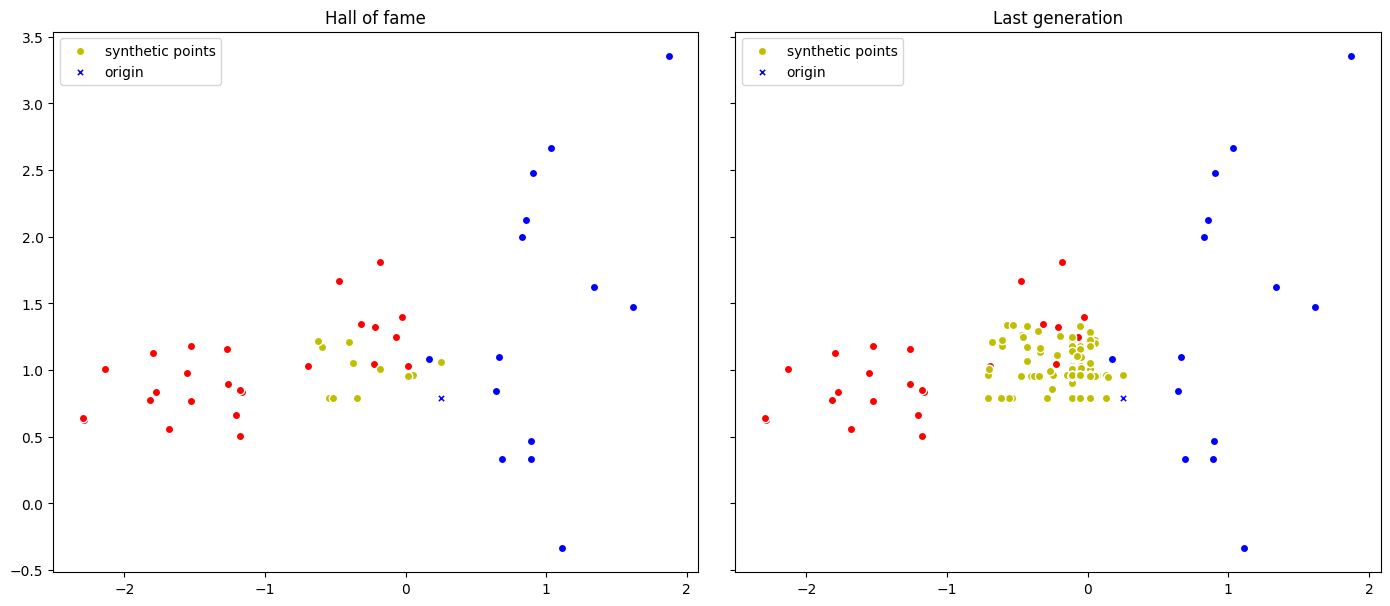

In [14]:
from ppga import tools, algorithms, log

target = (point_class + 1) % 2
toolbox.set_evaluation(evaluate, point, target, classifier, epsilon, 1.0)
toolbox.set_selection(tools.sel_tournament, tournsize=3)

hof = base.HallOfFame(50)
population, stats = algorithms.pelitist(
    toolbox=toolbox,
    population_size=500,
    keep=0.1,
    cxpb=0.8,
    mutpb=0.2,
    max_generations=100,
    hall_of_fame=hof,
)

hof_synth_points = np.array([i.chromosome for i in hof])
pop_synth_points = np.array([i.chromosome for i in population])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
plt.tight_layout()

ax1.set_title("Hall of fame")
ax1.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
ax1.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

ax1.scatter(
    hof_synth_points.T[0],
    hof_synth_points.T[1],
    c="y",
    ec="w",
    label="synthetic points",
)

c = "r" if point_class == 0 else "b"
ax1.scatter(point[0], point[1], c=c, ec="w", marker="X", label="origin")
ax1.legend()

ax2.set_title("Last generation")
ax2.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
ax2.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

ax2.scatter(
    pop_synth_points.T[0],
    pop_synth_points.T[1],
    c="y",
    ec="w",
    label="synthetic points",
)

c = "r" if point_class == 0 else "b"
ax2.scatter(point[0], point[1], c=c, ec="w", marker="X", label="origin")
ax2.legend()

plt.show()

#### Analisi

Come prima andiamo a dividere i punti sintetici per classe e andiamo
semplicemente a contare quanti di questi sono stati classificati nella classe
target rispetto al totale dei punti.


In [15]:
hof_cls = [classifier.predict(i.chromosome.reshape(1, -1))[0] for i in hof]

target_class = len([i for i in hof_cls if i == point_class])

print(f"point of the target class: {target_class}")
print(f"point of other class: {len(hof) - target_class}")
print(f"accuracy: {target_class / len(hof) * 100.0:.2f}%")

point of the target class: 40
point of other class: 10
accuracy: 80.00%


La Hall of Fame che ho implementato dovrebbe garantire diversità genetica
massima. Non in termini di differenza nei valori delle feature ma in termini
di duplicati. Nella Hall of Fame non possono infatti esserci individui
duplicati ed ha una semantica simile a quella di un _set_ ordinato per fitness
decrescente.
